# Case Study on Genetic Algorithms using the Knapsack Problem

This case study exemplarily demonstrates the programming of a genetiv algorithm and shows why mutation is crucial for genetic algorithms. Furthermore, we simulate scenarios with different numbers of chromosomes and visualize them. 

## What is a Genetic Algorithm
A genetic algorithm is an evolution-inspired algorithm that tries to find the optimal solution by survival of the fittest solution candidates (called chromosomes). It has five stages:

1. Creation of initial population
2. Evaluation of population by fitness function
3. Selection of fittest chromosome
4. Crossover of chromosomes to create new population 
5. Mutation of new chromosome

Stages 2-5 are repeated until convergence is achieved. More info can be found [here](https://towardsdatascience.com/introduction-to-genetic-algorithms-including-example-code-e396e98d8bf3).


## The Knapsack Problem
Provided you have a bag with limited capacity and a set of items with associated weight and value, what is the optimal combination of items to maximize the value of your bag? 

Or, more practical:

Given you managed to break into the tresor of Credit Suisse and are now standing in front of several different high value metals of differing value and weight. What is the value that optimizes the reward of your heist?

In [1]:
import numpy as np
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Creation of Item Set

A large item set is created to make efficiency gains visible. 

In [2]:
np.random.seed(42)
metal_ingot_number = np.arange(1,1001) 
weight      = np.random.randint(1,15, size = 1000) 
value       = np.random.randint(1,750, size = 1000) 
knapsack_threshold = 35 # capacity of our backpack

df = pd.DataFrame({'metal_ingot_number':metal_ingot_number,
                   'weight':weight,
                   'value':value})

## Creation of Initial Population

This population is a random binary initialisation of solutions. If it is 1, the item is included. If it is 0, the item is not included.

In [3]:
np.random.seed(42)

solutions_per_pop  = 8 
pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)
num_generations    = 2500 

print('Our initial population : \n \n', initial_population)

Our initial population : 
 
 [[0 1 0 ... 1 1 0]
 [1 0 0 ... 0 0 0]
 [0 1 1 ... 0 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [1 1 0 ... 1 0 0]]


## Exemplary Chromosome Solution Value Display

In [4]:
print('Selected items in our first chromosome of our starting population:\n')

weight_vec = [];
value_vec  = [];
for i in range(len(initial_population[0])):
    if initial_population[0][i] != 0:
        weight_vec.append(weight[i])
        value_vec.append(value[i])
print('with total weight: \n')
print(np.array(weight_vec).sum(),'\n')
print('and total value: \n')
print(np.array(value_vec).sum())

Selected items in our first chromosome of our starting population:

with total weight: 

3842 

and total value: 

190074


We see that this initial solution violates the weight constraint extremely. This is not too surprising, taking into account the way the initial item set is created. Consequently, any optimal solution has to be a sparse chromosome. 

## Design of Fitness Function

In [5]:
def cal_fitness(weight, value, population, threshold, allow_constraint_violations = True):
    
    fitness = np.empty(population.shape[0])
    
    for i in range(population.shape[0]):
        metal_value = np.sum(population[i] * value)
        metal_weight = np.sum(population[i] * weight)
        if metal_weight <= threshold:
            fitness[i] = metal_value
        elif allow_constraint_violations == True:
            fitness[i] = metal_value - 60 * metal_weight
        else:
            fitness[i] = 0 

    return(pd.DataFrame({'fitness': fitness}))

In [6]:
fitness_df = cal_fitness(weight, value, initial_population, knapsack_threshold)
display(fitness_df)

,fitness
0,-40446.0
1,-29849.0
2,-38110.0
3,-37779.0
4,-36893.0
5,-48961.0
6,-29317.0
7,-40535.0


The initial population violates the constraints by quite a lot. Consequently, they all have negative fitness (or total reward).

## Selection

50 percent of the population survives. Bye bye to the rest!

In [7]:
def selection(fitness_df, population, num_parents, selection = True):
    
    if selection == True:
        parents_df = fitness_df.sort_values('fitness', ascending=False).reset_index()[:num_parents]
        parents    = population[parents_df['index']]
        
    else:
        parents_df = fitness_df.sort_values('fitness', ascending=False).reset_index()
        parents    = population[parents_df['index']]
        
    return(parents)

selection_df = selection(fitness_df, initial_population, int(pop_size[0]/2))

## Crossover & Mutation

Welcome to the mating period! Here, we create new offsprings. The chromosomes then mutate at certain probability.

As we want to compare how the algorithm behaves without mutation or crossover, we include loops to either prevent mutation or prevent crossover. We cannot maintain selection and abandon crossover at the same time as we would diminish our population by doing so. Consequently, we duplicate the best samples. 

In [16]:
np.random.seed(42)
def cross_over_mutation(solutions_per_pop, parents, mutation = True, crossover = True):
    
    if crossover == True:    
        children = [];
        desired_length = solutions_per_pop - len(parents)

        while len(children) < desired_length :
            male   = list(parents[np.random.randint(0,len(parents)-1)])
            female = list(parents[np.random.randint(0,len(parents)-1)])
            half = int(len(male)/2)
            child = male[:half] + female[half:]
            children.append(child)
            
    elif crossover == False: 
        children = parents
        
    # Mutation
    mutation_chance = 0.08
    if mutation == True:
        for child in children:
            if (mutation_chance > np.random.random()):
                r = np.random.randint(0,len(child)-1)
                if child[r] == 1:
                    child[r] = 0
                else:
                    child[r] = 1
    else:
        pass
    
    population = np.concatenate([parents, children], axis = 0)
        
    return(population)

## Optimization Function

In [15]:
def optimize(weight, value, population, num_generations, knapsack_threshold, mutation = True, crossover = True):
        
    pop_size = len(population[0])
    
    fitness_history = [];
    for i in range(num_generations):
        #print('Generation : ', i)
        fitness_df = cal_fitness(weight, value, population, knapsack_threshold)
        parents_df = selection(fitness_df, population, int(len(population)/2))
        fitness_history.append(fitness_df)
        
        if mutation == True and crossover == True:
            population = cross_over_mutation(len(population), parents_df)
            
        elif mutation == False and crossover == True:
            population = cross_over_mutation(len(population), parents_df, mutation = False)
            
        elif mutation == True and crossover == False:
            population = cross_over_mutation(len(population), parents_df, crossover = False)
            
            
        
    #print('Last generation: \n{}\n'.format(population)) 
    fitness_last_gen_df = cal_fitness(weight, value, population, knapsack_threshold)      
    #print('Fitness of the last generation: \n{}\n'.format(fitness_last_gen_df))
    return(fitness_history)

Quick and dirty solution to simulate 8, 16 and 32 chromosomes:

In [10]:
%%time
# 8 chromosomes
np.random.seed(42)
solutions_per_pop  = 8 
pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)
num_generations    = 20000

fitness_history = optimize(weight, value, initial_population, num_generations, knapsack_threshold)
fitness_history_no_mutation = optimize(weight, value, initial_population, num_generations, knapsack_threshold, mutation = False)
fitness_history_no_crossover = optimize(weight, value, initial_population, num_generations, knapsack_threshold, crossover = False)

Wall time: 1min 45s


In [11]:
%%time
# 16 chromosomes
np.random.seed(42)
solutions_per_pop  = 16
pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)

fitness_history_16 = optimize(weight, value, initial_population, num_generations, knapsack_threshold)
fitness_history_no_mutation_16 = optimize(weight, value, initial_population, num_generations, knapsack_threshold, mutation = False)
fitness_history_no_crossover_16 = optimize(weight, value, initial_population, num_generations, knapsack_threshold, crossover = False)

Wall time: 2min 31s


In [12]:
%%time
# 32 chromosomes
np.random.seed(42)
solutions_per_pop  = 32
pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)

fitness_history_32 = optimize(weight, value, initial_population, num_generations, knapsack_threshold)
fitness_history_no_mutation_32 = optimize(weight, value, initial_population, num_generations, knapsack_threshold, mutation = False)
fitness_history_no_crossover_32 = optimize(weight, value, initial_population, num_generations, knapsack_threshold, crossover = False)

Wall time: 3min 42s


## Results and Visualization

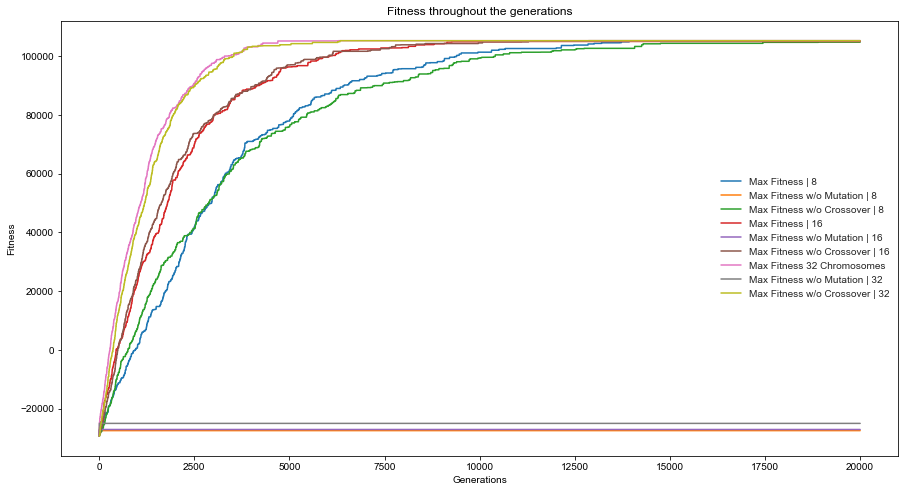

In [13]:
fig, axs = plt.subplots(figsize=(15, 8),nrows=1, ncols=1)
plt.style.use('seaborn-whitegrid')

fitness_history_max  = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness | 8')

fitness_history_no_mutation_max  = [np.max(fitness) for fitness in fitness_history_no_mutation]
plt.plot(list(range(num_generations)), fitness_history_no_mutation_max, label = 'Max Fitness w/o Mutation | 8')

fitness_history_no_crossover_max  = [np.max(fitness) for fitness in fitness_history_no_crossover]
plt.plot(list(range(num_generations)), fitness_history_no_crossover_max, label = 'Max Fitness w/o Crossover | 8')

fitness_history_max_16  = [np.max(fitness) for fitness in fitness_history_16]
plt.plot(list(range(num_generations)), fitness_history_max_16, label = 'Max Fitness | 16')

fitness_history_no_mutation_max_16  = [np.max(fitness) for fitness in fitness_history_no_mutation_16]
plt.plot(list(range(num_generations)), fitness_history_no_mutation_max_16, label = 'Max Fitness w/o Mutation | 16')

fitness_history_no_crossover_max_16  = [np.max(fitness) for fitness in fitness_history_no_crossover_16]
plt.plot(list(range(num_generations)), fitness_history_no_crossover_max_16, label = 'Max Fitness w/o Crossover | 16')

fitness_history_max_32  = [np.max(fitness) for fitness in fitness_history_32]
plt.plot(list(range(num_generations)), fitness_history_max_32, label = 'Max Fitness | 32')

fitness_history_no_mutation_max_32  = [np.max(fitness) for fitness in fitness_history_no_mutation_32]
plt.plot(list(range(num_generations)), fitness_history_no_mutation_max_32, label = 'Max Fitness w/o Mutation | 32')

fitness_history_no_crossover_max_32  = [np.max(fitness) for fitness in fitness_history_no_crossover_32]
plt.plot(list(range(num_generations)), fitness_history_no_crossover_max_32, label = 'Max Fitness w/o Crossover | 32')



plt.legend()
plt.title('Fitness throughout the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

fig.savefig("Mutation_on.pdf")

## Observations

Let's start with the most obvious observation: Mutation is crucial. Scenarios without mutation get stuck once they find the optimum for the random initialisation set. 

Interestingly enough, implementing crossover does not necessarily lead to huge performance improvements. They diminish with increasing number of chromosomes, which might be happening due to us using random crossover. Other crossover methods might lead to improvement on this end. 

Furthermore, the more chromosomes you have, the quicker the optimum is reached. This is not surprising as more chromosomes create a larger pool for the selection of the fittest. 